Note: the class can be found in sources/utilities/new_my_model_SezNet.py
and the configuration files are in models/model_SezNet

# Important note: this notebook has been ran using a GPU

#Data Exploration

In [ ]:
import pandas as pd

names = range(7)

d = {}

for name in names:
  df = pd.read_csv("./input{}.csv".format(name))
  columns_titles = ["Time", "input", "output1", "output2", "output3", "output4", "output5"]
  d['input{}'.format(name)] = df.reindex(columns=columns_titles)

In [ ]:
d['input0'].head()

,Time,input,output1,output2,output3,output4,output5
0,0.000,0.0,-2.464122e-07,0.5,0.5,1.011923,1.00983
1,0.001,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
2,0.002,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
3,0.003,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
4,0.004,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983


In [ ]:
# lenth of the different inputs
for name in names:
  print(d['input{}'.format(name)].shape[0])

10236
5001
3981
5000
5000
5000
5001


## Let's look at the data

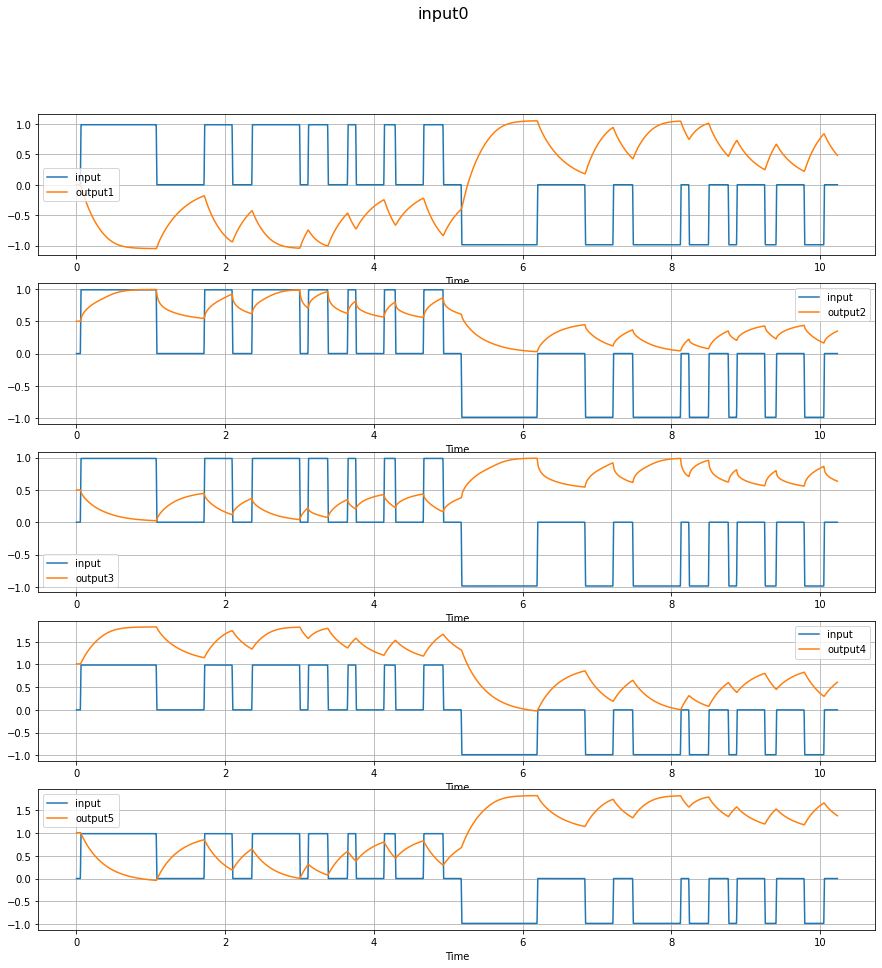

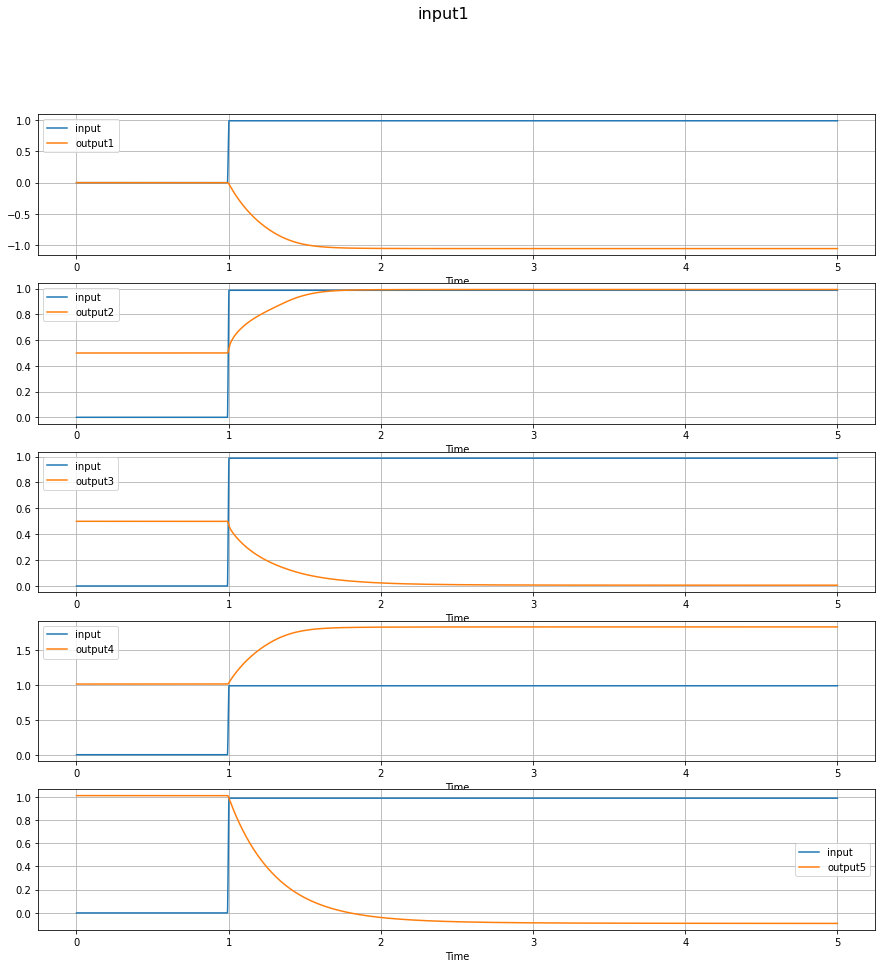

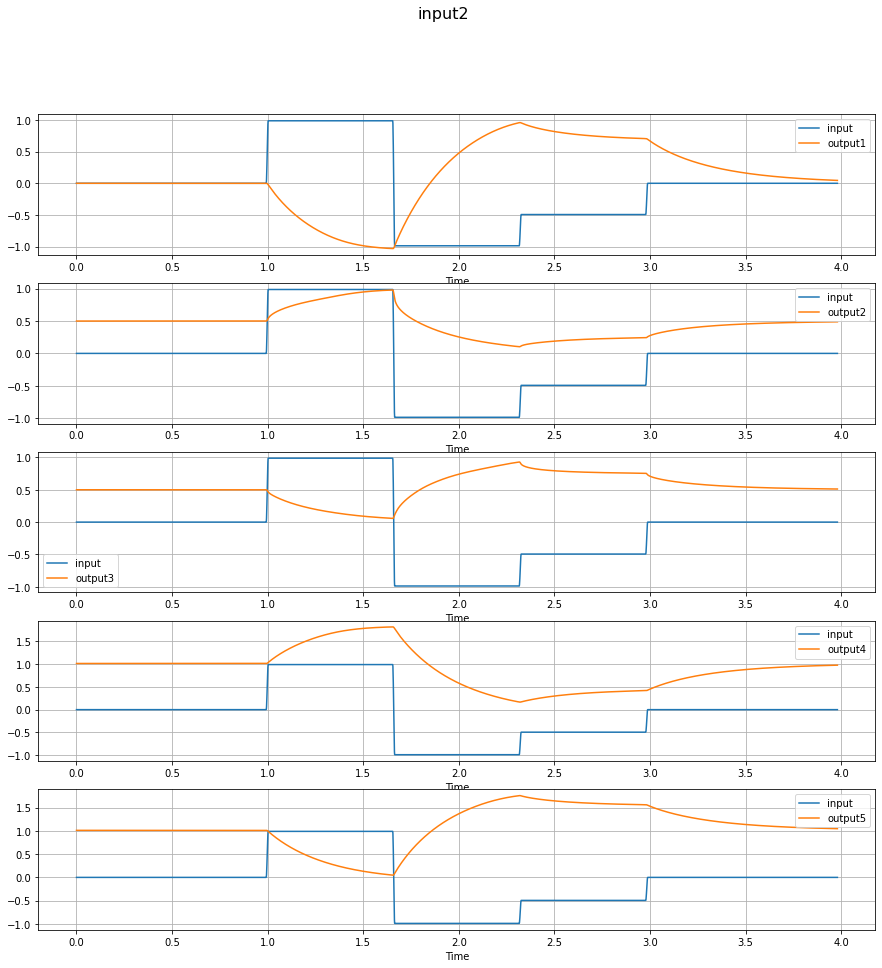

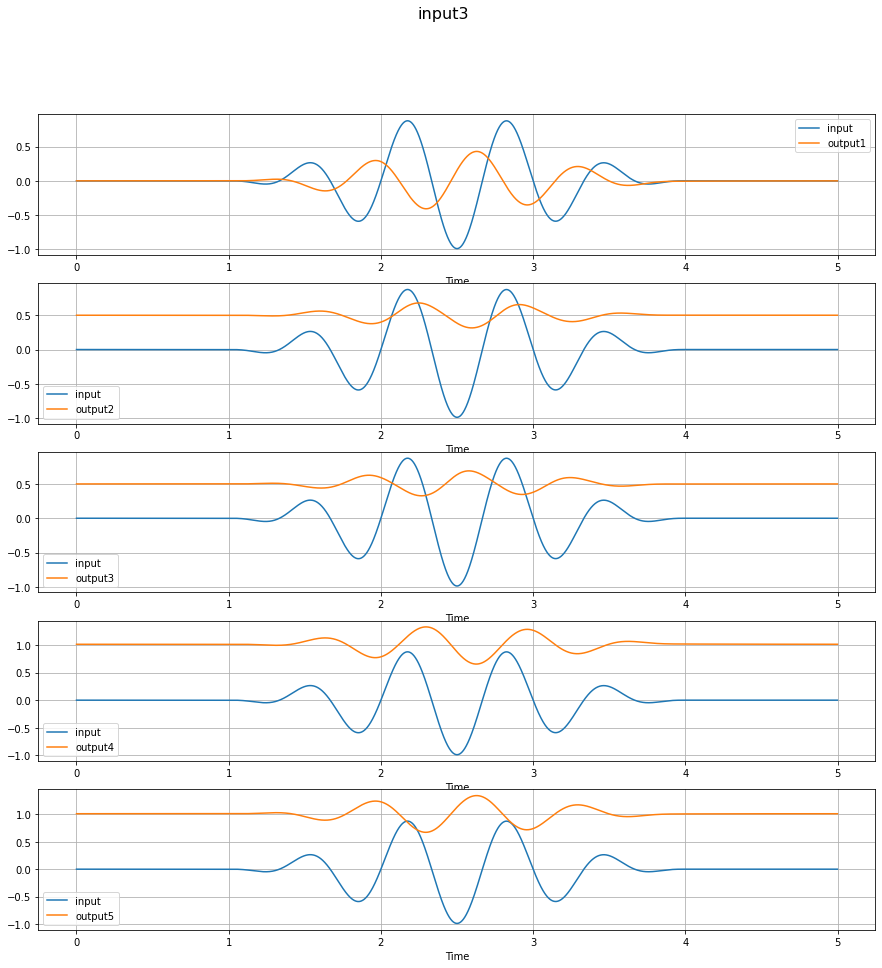

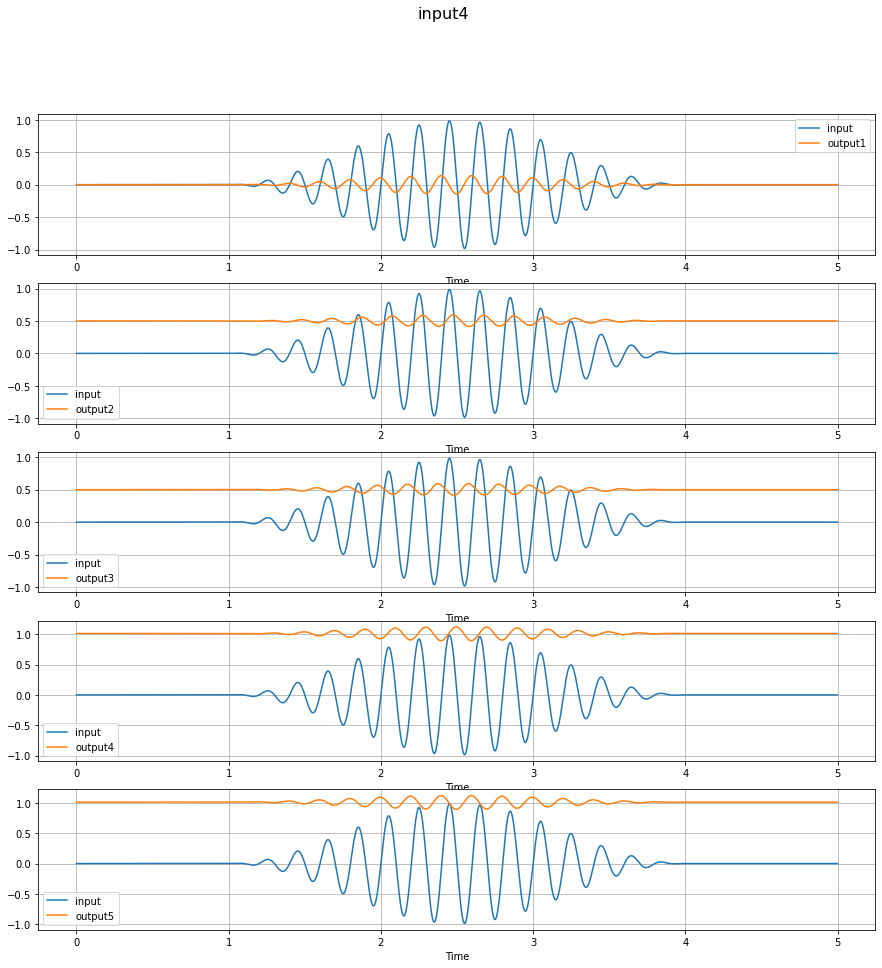

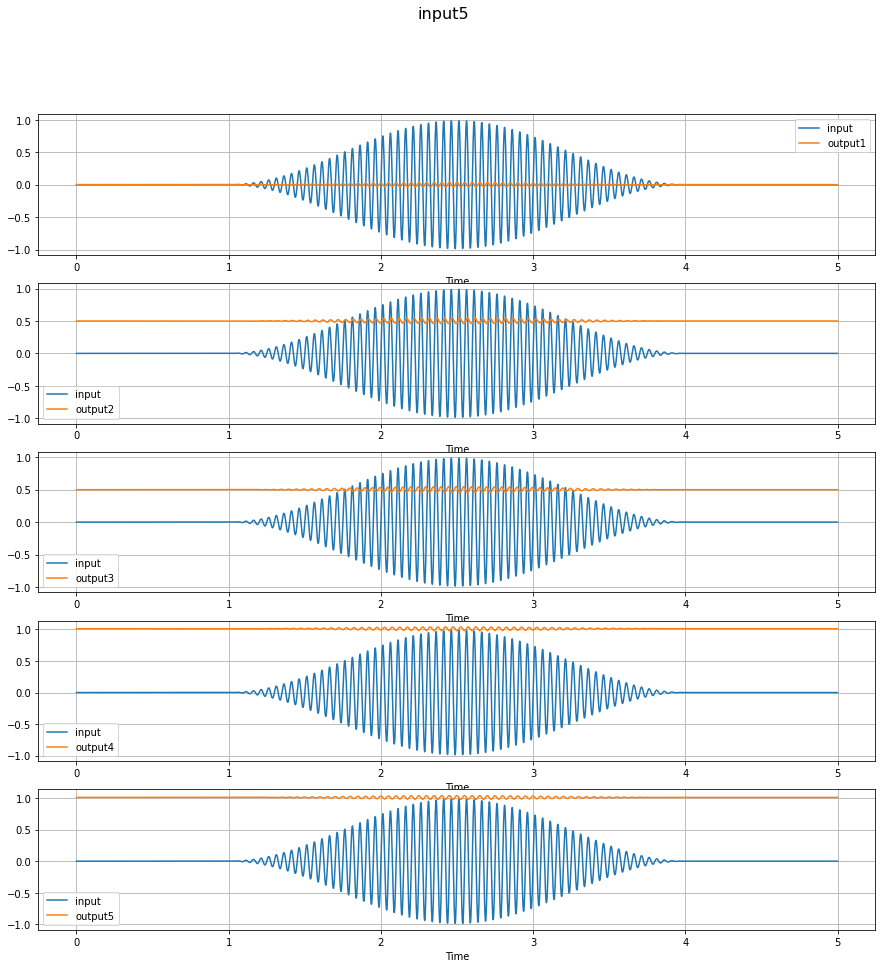

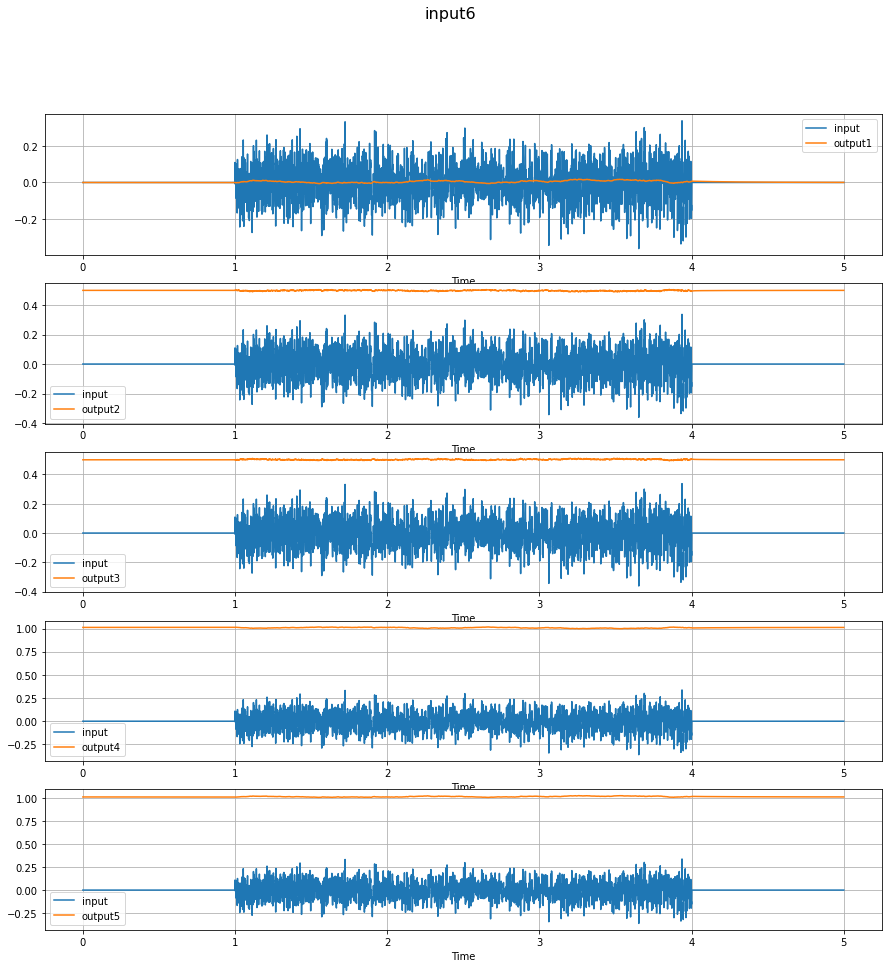

In [ ]:
import matplotlib.pyplot as plt

for name in names:
  fig, ax = plt.subplots(5,1,figsize=(15,15))
  fig.suptitle('input{}'.format(name), fontsize=16)
  for k in range(5):
    d['input{}'.format(name)].plot(ax=ax[k], x='Time',y=[1,k+2],grid='on')

In [ ]:
# average difference between two consecutive outputs
import numpy as np
deltas = d['input0'].diff()
deltas.apply(np.abs).mean(axis=0)

Time       0.001000
input      0.002702
output1    0.001511
output2    0.000791
output3    0.000793
output4    0.001295
output5    0.001301
dtype: float64

#Fetch data

In [ ]:
x = []
y = []
for i in range(7):
  x.append([d['input{}'.format(i)]['input'].values])
  ys = []
  for j in range(5):
    ys.append(d['input{}'.format(i)]['output{}'.format(j+1)].values)
  y.append(ys)

#Full csv

Building the training set from train_df.csv

In [ ]:
big_df = pd.read_csv('./train_df.csv')

n = big_df.shape[0]
time=[0]
for t in range(1, n):
  time.append(time[-1] + 1e-3)

big_df['Time'] = np.array(time)

big_x = [big_df['input'].values]
big_y = [big_df['output{}'.format(i+1)].values for i in range(5)]

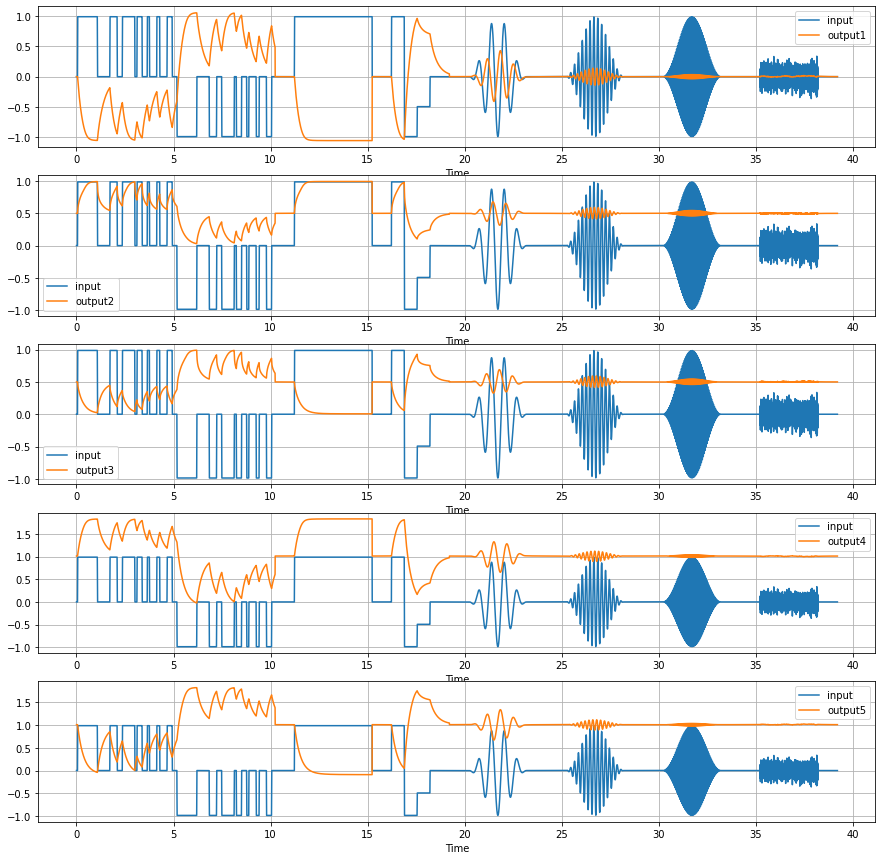

In [ ]:
fig, ax = plt.subplots(5,1,figsize=(15,15))
for k in range(5):
  big_df.plot(ax=ax[k], x='Time',y=[1,k+2],grid='on')

#Model

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Add, Conv1D, Concatenate, GRU, Reshape, LSTM, MaxPool1D, GaussianNoise, Dense, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from keras import Model
from tensorflow import optimizers
from keras.regularizers import L2
from keras import losses
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def rmse():
  def f(y_pred, y_true):
    mse = losses.MeanSquaredError()
    return tf.sqrt(mse(y_pred, y_true))
  return f

#NMSE
def loss_(y_test, y_pred):
  max_ytest_value = np.zeros( (5,1) )
  for k in range(5) : 
      max_ytest_value[k] = np.max(np.abs(y_test[:,k]))
      
  metric_normalized_mse = np.zeros( (5,) )
  for k in range(5):
      metric_normalized_mse[k] = mean_squared_error(y_true=y_test[:,k]/max_ytest_value[k], y_pred=y_pred[:,k]/max_ytest_value[k])

  weights_mse = np.array( [1,1,1,1,1] )

  return np.dot(weights_mse,metric_normalized_mse)

class Seq2seq_memory:

  def __init__(self, window=100, lr=0.0001, batch_size=32):

    self.window = window
    self.batch_size = batch_size
    self.epochs = 75
    self.test_split = .1

    #model1

    input1 = Input(shape=(window + 5 * 2))
    x1, x2, x3 = Lambda( lambda x: tf.split(x, [window] + [5] * 2, axis=1))(input1)

    deltas = tf.subtract(x3, x2)
    
    x1 = Reshape((1, window))(x1)

    x1 = Conv1D(32, 10, padding='same')(x1)

    x1 = GRU(64, return_sequences=True)(x1)
    x1 = GRU(64, return_sequences=True)(x1)
    x1 = GRU(64, return_sequences=True)(x1)
    
    _, states = GRU(5, return_sequences=False, return_state=True)(x1, initial_state=deltas)

    output1 = Add()([states, x2])
    
    self.model = Model(input1, output1)
    self.model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=rmse())
  
  def summary(self):
    self.model.summary()
    plot_model(self.model)
  
  def fit(self, xs, ys):
    print('Preprocessing data')
    print(xs[0].shape)
    input_lengths = [10236,5001,3981,5000,5000,5000,5001]
    Xs = []
    Ys = []
    count = 0
    for i_l in input_lengths:
        xs_i = xs[0][count: i_l+count]
        ys_i = []
        for y in ys:
          ys_i.append(np.pad(y[count: count+i_l], (self.window, 0), constant_values=y[count: count+i_l][0]))
        input = np.pad(xs_i, (self.window, 0), constant_values=xs_i[0])
        X = np.zeros((ys_i[0].shape[0] - 1, self.window + 5 * 2))
        Y = np.zeros((ys_i[0].shape[0] - 1, 5))
        for t in range(self.window, input.shape[0]):
          X[t - self.window, :] = np.concatenate([input[t - self.window + 1: t + 1], np.array([ys_i[0][t - 1], ys_i[1][t - 1], ys_i[2][t - 1], 
                                                                                          ys_i[3][t - 1], ys_i[4][t - 1]]), 
                                                          np.array([ys_i[0][t - 2], ys_i[1][t - 2], ys_i[2][t - 2], 
                                                                                          ys_i[3][t - 2], ys_i[4][t - 2]])])
          Y[t - self.window, :] = np.array([ys_i[i][t] for i in range(5)])
        Ys.append(Y)
        Xs.append(X)
        count += i_l
    
    self.X = np.concatenate(Xs, axis=0)
    self.Y = np.concatenate(Ys, axis=0)
    print('len(x) for training:')
    print(int((1 - self.test_split) * self.X.shape[0]))

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.Y, test_size=self.test_split, shuffle=True)
    
    print('Start training :')
    history = self.model.fit(x=self.x_train, y=self.y_train, batch_size=self.batch_size, epochs=self.epochs, validation_split=.15, shuffle=True)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
  
  def test(self):
    y_pred = self.model.predict(self.x_test)
    loss = pd.DataFrame(np.sqrt((y_pred - self.y_test)**2), columns=['output{}'.format(i) for i in range(1, 6)])
    print('loss on test set : {}'.format(loss_(self.y_test, y_pred)))
    print('rmse on test set : {}'.format(rmse()(self.y_test, y_pred)))
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca()
    loss.plot.hist(bins=100, ax=ax)
    plt.xlabel('rse')
    plt.show()
    for out in loss:
      print('{} loss attributes :'.format(out))
      print('{}\n'.format(pd.Series(loss[out].values).describe()))

  def predict_timeseries(self, x, y): #y is only required for the plot 
    #preprocess
    input = np.pad(x[0], (self.window, 0), constant_values=x[0][0])
    outputs = np.zeros((input.shape[0], 5))
    # shift to start
    outputs[:self.window, 0] = (x[0][0] - 2.464122e-7)
    outputs[:self.window, 1] = (x[0][0] + 0.5)
    outputs[:self.window, 2] = (x[0][0] + 0.5)
    outputs[:self.window, 3] = (x[0][0] + 1.011883)
    outputs[:self.window, 4] = (x[0][0] + 1.00983)
    for t in range(self.window, input.shape[0]):
        if (t - self.window) % 100 == 0:
            print('{}/{} predicted points'.format(t - self.window, input.shape[0] - self.window))
        input_seq = np.expand_dims(np.concatenate([input[t - self.window + 1: t + 1], 
                                                   np.array([outputs[t - 1, 0], outputs[t - 1, 1],
                                                  outputs[t - 1, 2], outputs[t - 1, 3], outputs[t - 1, 4]]),
                                                   np.array([outputs[t - 2, 0], outputs[t - 2, 1],
                                                  outputs[t - 2, 2], outputs[t - 2, 3], outputs[t - 2, 4]])]),
                                    axis=0)
        output_pred = self.model.predict(input_seq)[0]
        outputs[t, :] = output_pred
    df = pd.DataFrame(x[0], columns=['input'])
    for i in range(5):
      df['output{}'.format(i+1)] = y[i]
    for j in range(5):
      df['output{} predicted'.format(j+1)] = outputs[self.window:, j]
    fig, ax = plt.subplots(5,1,figsize=(15,15))
    fig.suptitle('input{}'.format(name), fontsize=16)
    for k in range(5):
      df.plot(ax=ax[k], y=[0, k+1, k+6], grid='on')
    Y = np.zeros((y[0].shape[0], 5))
    for i in range(5):
      Y[:, i] = y[i]
    print('loss : {}'.format(loss_(outputs[self.window:], Y)))


### Model Description

See slides to get an schema of the architecture

In [ ]:
my_model = Seq2seq_memory(window=700, batch_size=32)
my_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 710)]        0           []                               
                                                                                                  
 lambda_19 (Lambda)             [(None, 700),        0           ['input_15[0][0]']               
                                 (None, 5),                                                       
                                 (None, 5)]                                                       
                                                                                                  
 reshape_19 (Reshape)           (None, 1, 700)       0           ['lambda_19[0][0]']              
                                                                                           

#Model train & test

Trainign for 75 epochs on the train data built earlier, using the RMSE as loss.
We also display the learning curves for train and val losses, as well as the histogram of errors on the test set. You can also have a look at the distribution of the errors per signal by examining the quartiles and max to get a better understanding of the histogram.

Preprocessing data
(39219,)
len(x) for training:
39700
Start training :
Epoch 1/75
1055/1055 [==============================] - 13s 8ms/step - loss: 6.1852e-04 - val_loss: 3.5989e-04
Epoch 2/75
1055/1055 [==============================] - 6s 6ms/step - loss: 4.1018e-04 - val_loss: 4.0605e-04
Epoch 3/75
1055/1055 [==============================] - 6s 6ms/step - loss: 3.6875e-04 - val_loss: 2.9389e-04
Epoch 4/75
1055/1055 [==============================] - 6s 6ms/step - loss: 3.3084e-04 - val_loss: 2.5540e-04
Epoch 5/75
1055/1055 [==============================] - 6s 6ms/step - loss: 3.1381e-04 - val_loss: 2.6244e-04
Epoch 6/75
1055/1055 [==============================] - 6s 6ms/step - loss: 2.8792e-04 - val_loss: 2.3367e-04
Epoch 7/75
1055/1055 [==============================] - 6s 6ms/step - loss: 2.7304e-04 - val_loss: 2.5611e-04
Epoch 8/75
1055/1055 [==============================] - 6s 6ms/step - loss: 2.6152e-04 - val_loss: 2.1497e-04
Epoch 9/75
1055/1055 [=========================

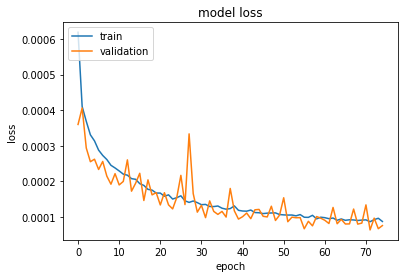

Training time: 490.5892872810364
loss on test set : 3.027172837757536e-08
rmse on test set : 8.211245585698634e-05


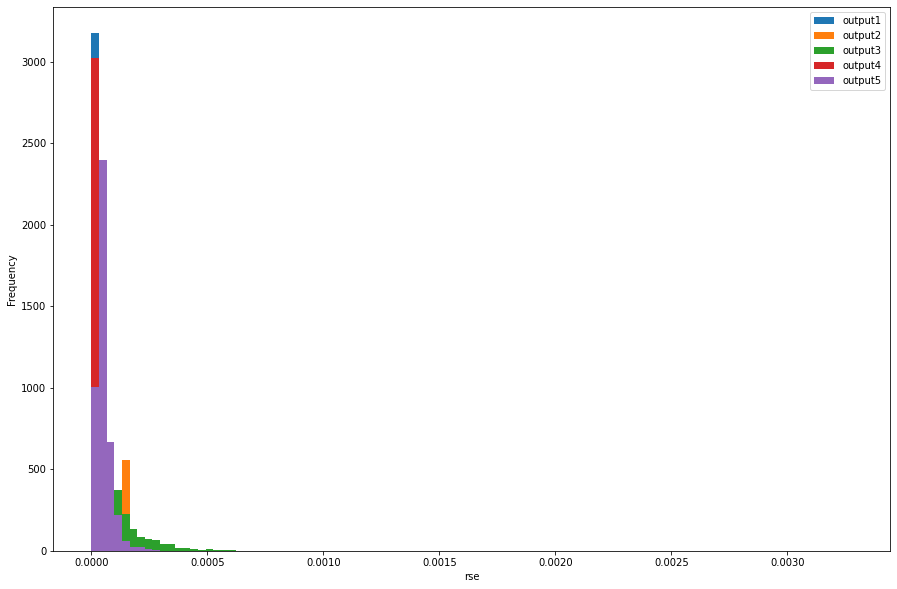

output1 loss attributes :
count    4.412000e+03
mean     2.368940e-05
std      2.603679e-05
min      1.073533e-08
25%      5.796323e-06
50%      1.355145e-05
75%      3.618929e-05
max      4.922263e-04
dtype: float64

output2 loss attributes :
count    4.412000e+03
mean     6.337515e-05
std      9.035045e-05
min      2.973090e-08
25%      1.502040e-05
50%      2.939173e-05
75%      9.878910e-05
max      3.280442e-03
dtype: float64

output3 loss attributes :
count    4.412000e+03
mean     8.301881e-05
std      8.984195e-05
min      6.160017e-09
25%      4.445179e-05
50%      4.547832e-05
75%      9.948345e-05
max      1.484099e-03
dtype: float64

output4 loss attributes :
count    4.412000e+03
mean     2.640097e-05
std      3.143569e-05
min      8.780090e-09
25%      2.739096e-06
50%      1.393074e-05
75%      4.393978e-05
max      6.636083e-04
dtype: float64

output5 loss attributes :
count    4.412000e+03
mean     5.021918e-05
std      3.358078e-05
min      1.063454e-07
25%      3.575

In [ ]:
#train

from time import time

t = time()

my_model.fit(big_x, big_y)

print("Training time: {}".format(time() - t))

my_model.test()

## Predicting time series

We display the results as well as the NMSE for each input.
Because of the errors made by the model, it does not get to encounter the same points as during training since the outputs it predicts will be slightly erroneous.

0/10236 predicted points
100/10236 predicted points
200/10236 predicted points
300/10236 predicted points
400/10236 predicted points
500/10236 predicted points
600/10236 predicted points
700/10236 predicted points
800/10236 predicted points
900/10236 predicted points
1000/10236 predicted points
1100/10236 predicted points
1200/10236 predicted points
1300/10236 predicted points
1400/10236 predicted points
1500/10236 predicted points
1600/10236 predicted points
1700/10236 predicted points
1800/10236 predicted points
1900/10236 predicted points
2000/10236 predicted points
2100/10236 predicted points
2200/10236 predicted points
2300/10236 predicted points
2400/10236 predicted points
2500/10236 predicted points
2600/10236 predicted points
2700/10236 predicted points
2800/10236 predicted points
2900/10236 predicted points
3000/10236 predicted points
3100/10236 predicted points
3200/10236 predicted points
3300/10236 predicted points
3400/10236 predicted points
3500/10236 predicted points
3600

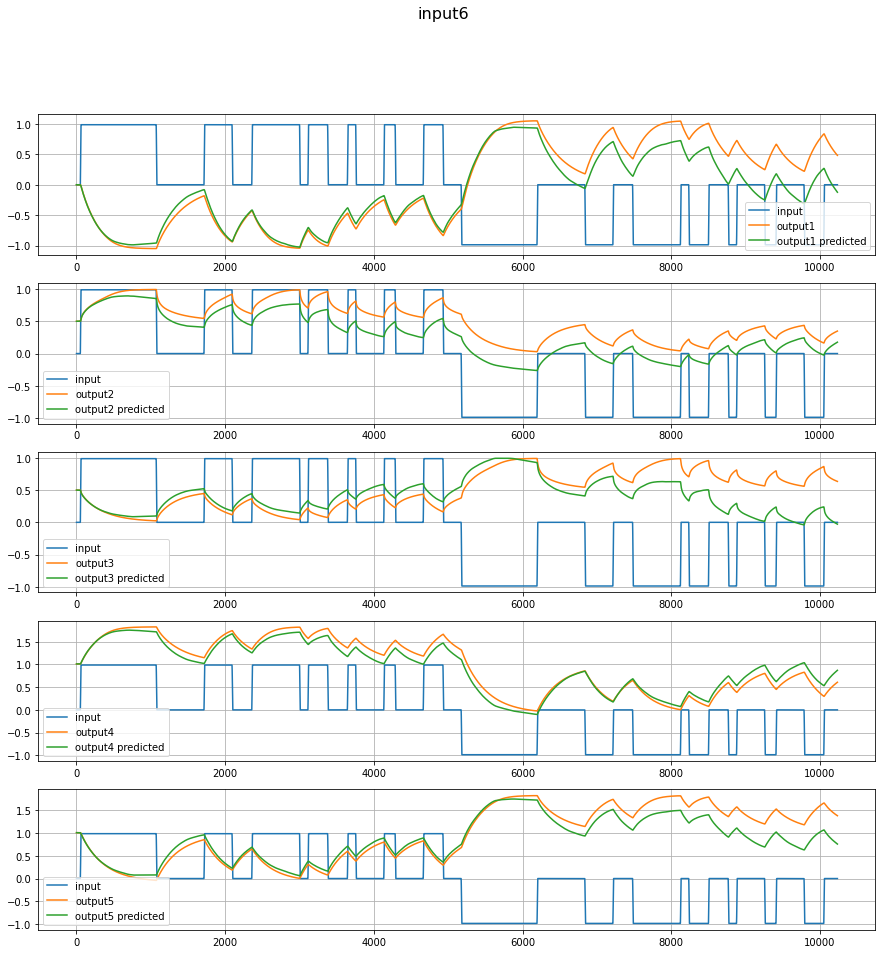

In [ ]:
#input 1

t=time() 

my_model.predict_timeseries(x[0], y[0])

print("Prediction time online: {}".format(time()-t))

0/5001 predicted points
100/5001 predicted points
200/5001 predicted points
300/5001 predicted points
400/5001 predicted points
500/5001 predicted points
600/5001 predicted points
700/5001 predicted points
800/5001 predicted points
900/5001 predicted points
1000/5001 predicted points
1100/5001 predicted points
1200/5001 predicted points
1300/5001 predicted points
1400/5001 predicted points
1500/5001 predicted points
1600/5001 predicted points
1700/5001 predicted points
1800/5001 predicted points
1900/5001 predicted points
2000/5001 predicted points
2100/5001 predicted points
2200/5001 predicted points
2300/5001 predicted points
2400/5001 predicted points
2500/5001 predicted points
2600/5001 predicted points
2700/5001 predicted points
2800/5001 predicted points
2900/5001 predicted points
3000/5001 predicted points
3100/5001 predicted points
3200/5001 predicted points
3300/5001 predicted points
3400/5001 predicted points
3500/5001 predicted points
3600/5001 predicted points
3700/5001 pre

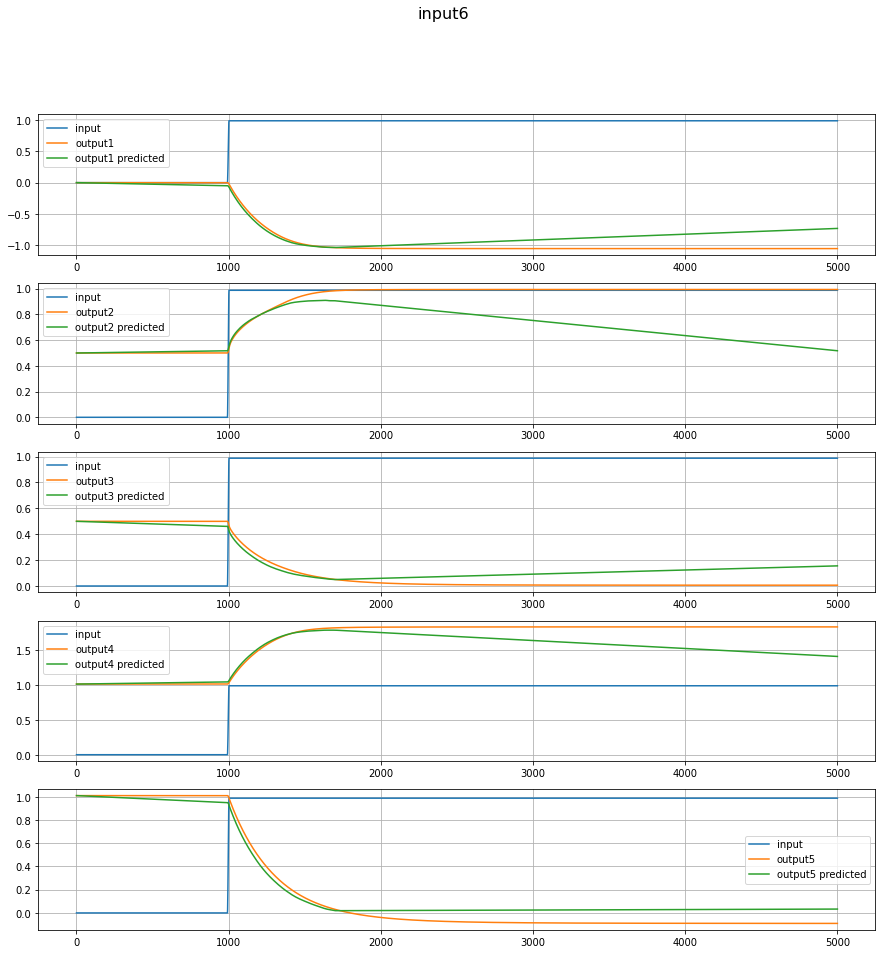

In [ ]:
#input 2

t=time() 
my_model.predict_timeseries(x[1], y[1])
print("Prediction time online: {}".format(time()-t))

0/3981 predicted points
100/3981 predicted points
200/3981 predicted points
300/3981 predicted points
400/3981 predicted points
500/3981 predicted points
600/3981 predicted points
700/3981 predicted points
800/3981 predicted points
900/3981 predicted points
1000/3981 predicted points
1100/3981 predicted points
1200/3981 predicted points
1300/3981 predicted points
1400/3981 predicted points
1500/3981 predicted points
1600/3981 predicted points
1700/3981 predicted points
1800/3981 predicted points
1900/3981 predicted points
2000/3981 predicted points
2100/3981 predicted points
2200/3981 predicted points
2300/3981 predicted points
2400/3981 predicted points
2500/3981 predicted points
2600/3981 predicted points
2700/3981 predicted points
2800/3981 predicted points
2900/3981 predicted points
3000/3981 predicted points
3100/3981 predicted points
3200/3981 predicted points
3300/3981 predicted points
3400/3981 predicted points
3500/3981 predicted points
3600/3981 predicted points
3700/3981 pre

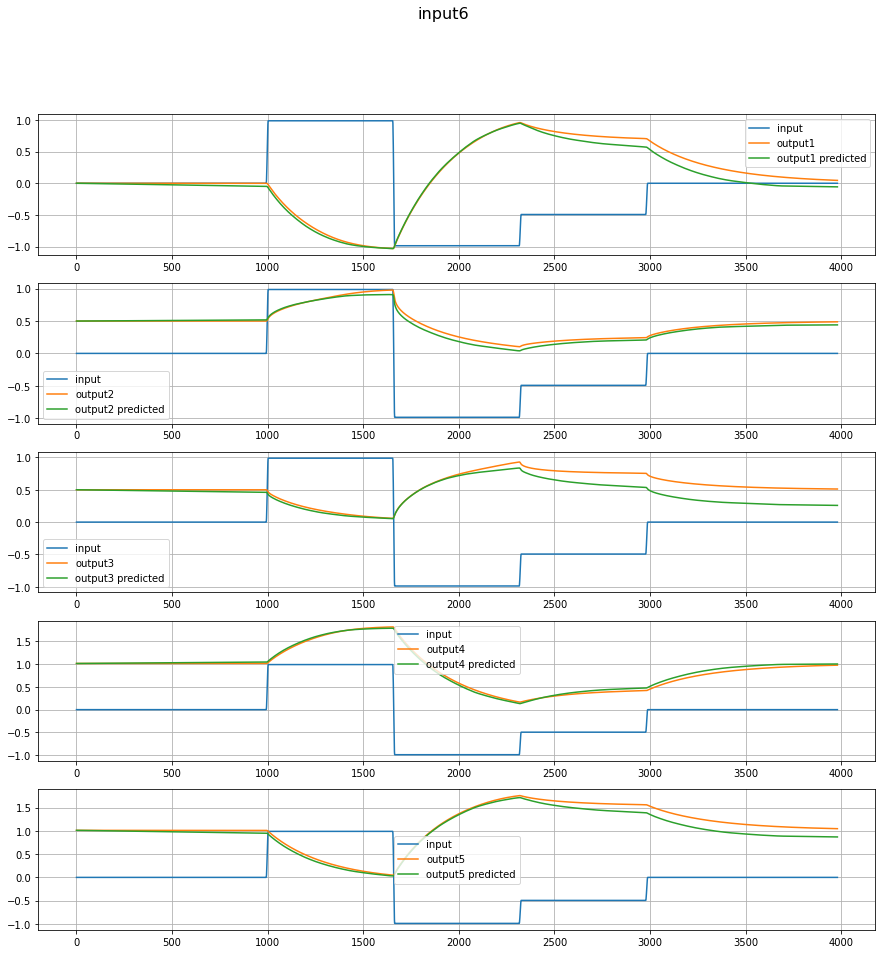

In [ ]:
#input 3

t=time() 
my_model.predict_timeseries(x[2], y[2])
print("Prediction time online: {}".format(time()-t))

0/5000 predicted points
100/5000 predicted points
200/5000 predicted points
300/5000 predicted points
400/5000 predicted points
500/5000 predicted points
600/5000 predicted points
700/5000 predicted points
800/5000 predicted points
900/5000 predicted points
1000/5000 predicted points
1100/5000 predicted points
1200/5000 predicted points
1300/5000 predicted points
1400/5000 predicted points
1500/5000 predicted points
1600/5000 predicted points
1700/5000 predicted points
1800/5000 predicted points
1900/5000 predicted points
2000/5000 predicted points
2100/5000 predicted points
2200/5000 predicted points
2300/5000 predicted points
2400/5000 predicted points
2500/5000 predicted points
2600/5000 predicted points
2700/5000 predicted points
2800/5000 predicted points
2900/5000 predicted points
3000/5000 predicted points
3100/5000 predicted points
3200/5000 predicted points
3300/5000 predicted points
3400/5000 predicted points
3500/5000 predicted points
3600/5000 predicted points
3700/5000 pre

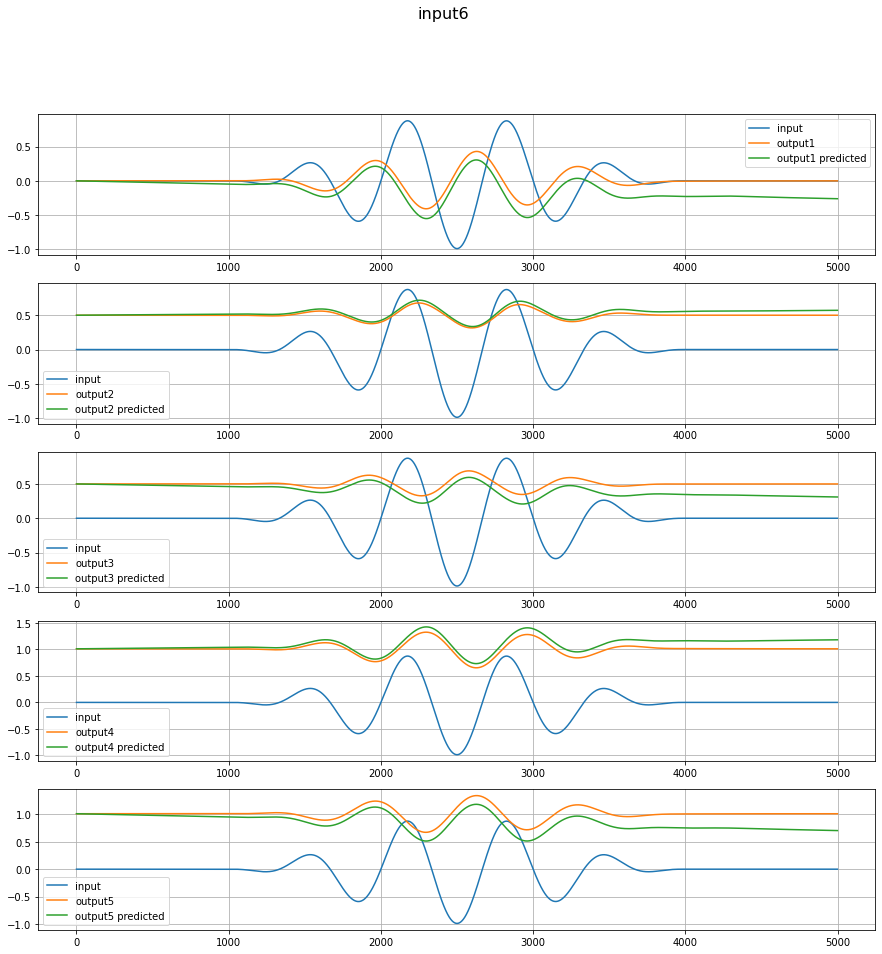

In [ ]:
#input 4

t=time() 
my_model.predict_timeseries(x[3], y[3])
print("Prediction time online: {}".format(time()-t))

0/5000 predicted points
100/5000 predicted points
200/5000 predicted points
300/5000 predicted points
400/5000 predicted points
500/5000 predicted points
600/5000 predicted points
700/5000 predicted points
800/5000 predicted points
900/5000 predicted points
1000/5000 predicted points
1100/5000 predicted points
1200/5000 predicted points
1300/5000 predicted points
1400/5000 predicted points
1500/5000 predicted points
1600/5000 predicted points
1700/5000 predicted points
1800/5000 predicted points
1900/5000 predicted points
2000/5000 predicted points
2100/5000 predicted points
2200/5000 predicted points
2300/5000 predicted points
2400/5000 predicted points
2500/5000 predicted points
2600/5000 predicted points
2700/5000 predicted points
2800/5000 predicted points
2900/5000 predicted points
3000/5000 predicted points
3100/5000 predicted points
3200/5000 predicted points
3300/5000 predicted points
3400/5000 predicted points
3500/5000 predicted points
3600/5000 predicted points
3700/5000 pre

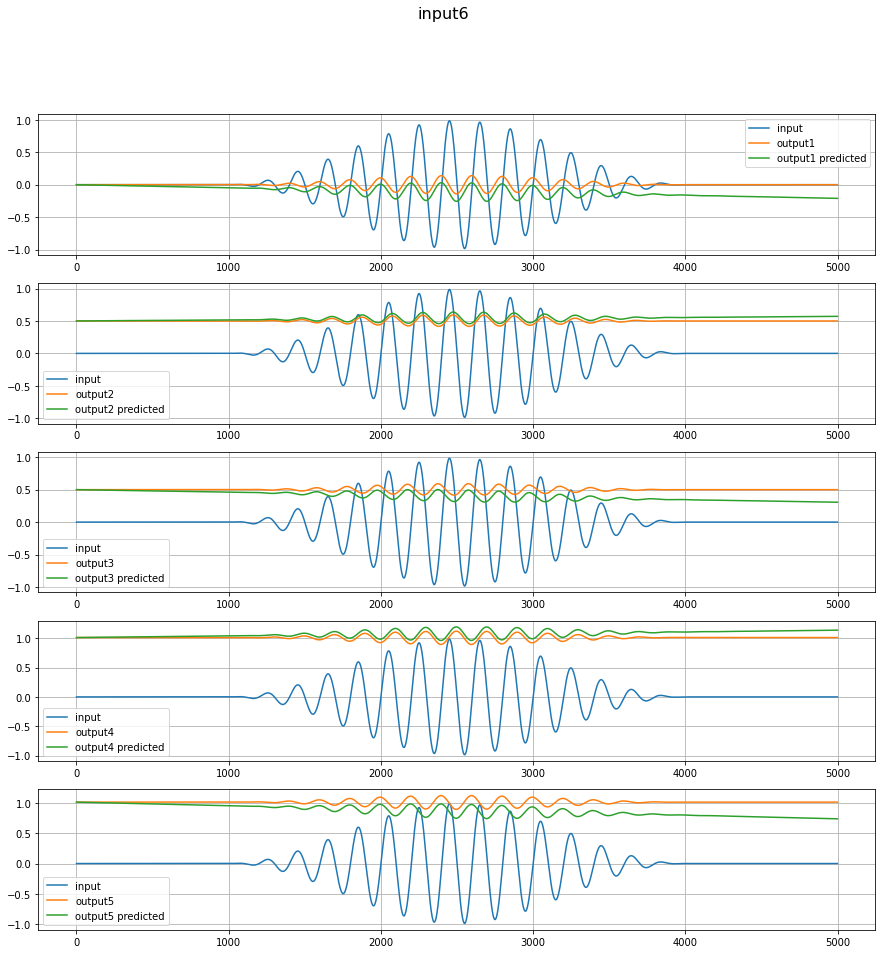

In [ ]:
#input 5

t=time() 
my_model.predict_timeseries(x[4], y[4])
print("Prediction time online: {}".format(time()-t))

0/5000 predicted points
100/5000 predicted points
200/5000 predicted points
300/5000 predicted points
400/5000 predicted points
500/5000 predicted points
600/5000 predicted points
700/5000 predicted points
800/5000 predicted points
900/5000 predicted points
1000/5000 predicted points
1100/5000 predicted points
1200/5000 predicted points
1300/5000 predicted points
1400/5000 predicted points
1500/5000 predicted points
1600/5000 predicted points
1700/5000 predicted points
1800/5000 predicted points
1900/5000 predicted points
2000/5000 predicted points
2100/5000 predicted points
2200/5000 predicted points
2300/5000 predicted points
2400/5000 predicted points
2500/5000 predicted points
2600/5000 predicted points
2700/5000 predicted points
2800/5000 predicted points
2900/5000 predicted points
3000/5000 predicted points
3100/5000 predicted points
3200/5000 predicted points
3300/5000 predicted points
3400/5000 predicted points
3500/5000 predicted points
3600/5000 predicted points
3700/5000 pre

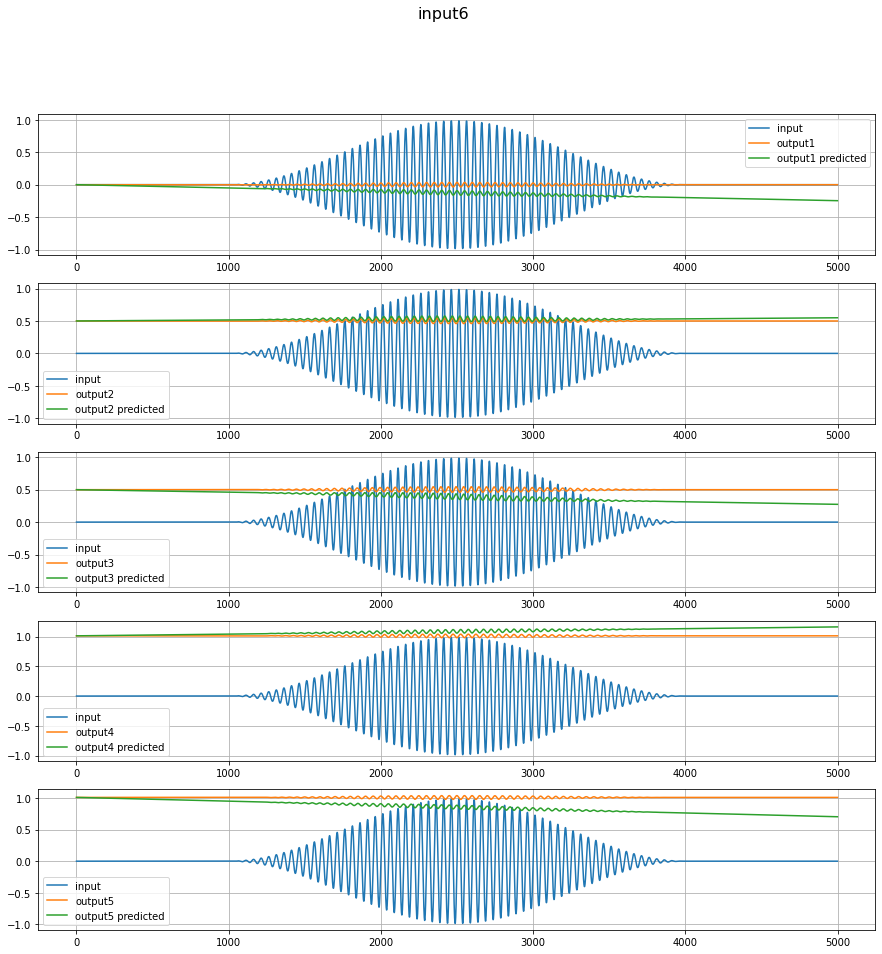

In [ ]:
#input 6

t=time() 
my_model.predict_timeseries(x[5], y[5])
print("Prediction time online: {}".format(time()-t))

0/5001 predicted points
100/5001 predicted points
200/5001 predicted points
300/5001 predicted points
400/5001 predicted points
500/5001 predicted points
600/5001 predicted points
700/5001 predicted points
800/5001 predicted points
900/5001 predicted points
1000/5001 predicted points
1100/5001 predicted points
1200/5001 predicted points
1300/5001 predicted points
1400/5001 predicted points
1500/5001 predicted points
1600/5001 predicted points
1700/5001 predicted points
1800/5001 predicted points
1900/5001 predicted points
2000/5001 predicted points
2100/5001 predicted points
2200/5001 predicted points
2300/5001 predicted points
2400/5001 predicted points
2500/5001 predicted points
2600/5001 predicted points
2700/5001 predicted points
2800/5001 predicted points
2900/5001 predicted points
3000/5001 predicted points
3100/5001 predicted points
3200/5001 predicted points
3300/5001 predicted points
3400/5001 predicted points
3500/5001 predicted points
3600/5001 predicted points
3700/5001 pre

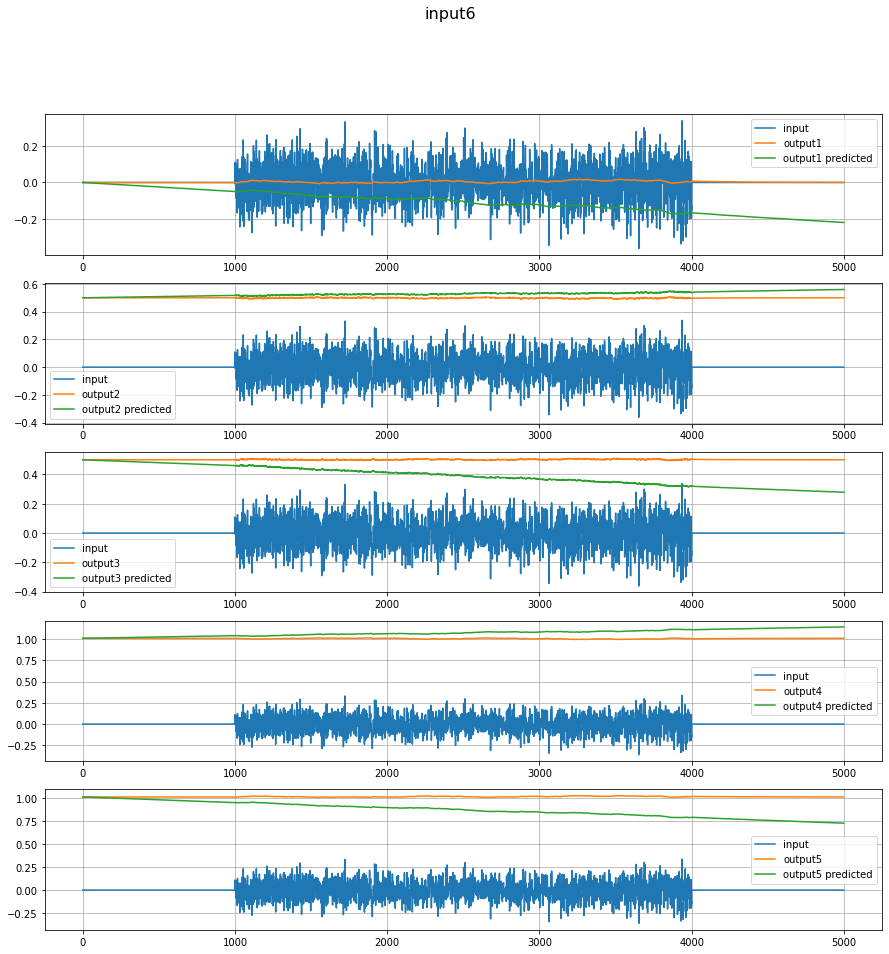

In [ ]:
#input 7

t=time() 
my_model.predict_timeseries(x[6], y[6])
print("Prediction time online: {}".format(time()-t))